# Math 4383 Project
### Zachary Koenig, Colin Crippen

In [195]:
!pip install matplotlib

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import csv

In [197]:
# --- Load the 8x8 digits dataset ---
digits = load_digits()

# The dataset contains 8x8 images and their corresponding digit labels.
# X contains image data and y contains the target labels.
X = digits.images      # Shape: (n_samples, 8, 8)
y = digits.target      # Shape: (n_samples,)

# --- Data Preprocessing ---

# 1. Flatten the images:
#    Convert each 8x8 image into a 1D array of 64 pixels.
n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1)   # Now shape is (n_samples, 64)

# 2. Normalize the inputs:
#    The pixel values in the digits dataset are in the range 0-16.
#    Dividing by 16 scales them to the range [0, 1].
X_normalized = X_flat / 16.0

# 3. One-Hot Encode the Labels:
#    There are 10 classes (digits 0-9), so create one-hot encoded vectors.
num_classes = 10
y_onehot = np.eye(num_classes)[y]

# --- Split into Training and Verification (Validation) Sets ---
# For example, reserve 20% of the data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, y_onehot, test_size=0.2, random_state=42
)

# Verify the shapes
print("Training set shape:", X_train.shape, y_train.shape)  # Should show ~80% of the samples
print("Validation set shape:", X_val.shape, y_val.shape)      # Should show ~20% of the samples
print("One-hot encoded y shape:", y_onehot.shape)    # Expected: (n_samples, 10)

Training set shape: (1437, 64) (1437, 10)
Validation set shape: (360, 64) (360, 10)
One-hot encoded y shape: (1797, 10)


Sigmoid function to enable nonlinear function representation

In [198]:
# --- Activation functions and their derivatives ---

def sigmoid(x):
    """Compute the sigmoid activation."""
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """Compute the derivative of the sigmoid function."""
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x):
    """Compute the softmax activation for each row of x."""
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return exps / np.sum(exps, axis=1, keepdims=True)

In [199]:
# --- Hyperparameters ---
input_size = 8 * 8   # 64 inputs, one per pixel
hidden_size = 64       # You can adjust this
output_size = 10       # 10 classes for digits 0-9

learning_rate = 0.1
epochs = 20_000

# --- Initialize Weights and Biases ---
np.random.seed(72)  # For reproducibility
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

In [200]:
# --- Lists to Save Progress Data ---
progress_data = []  # Each element: (epoch, loss, accuracy)

# --- Training Loop ---
num_train_samples = X_train.shape[0]  # Use real number of training samples
for epoch in range(epochs):
    # Forward pass:
    Z1 = np.dot(X_train, W1) + b1       # Input to hidden layer
    A1 = sigmoid(Z1)                   # Hidden layer activation
    Z2 = np.dot(A1, W2) + b2            # Hidden to output layer
    A2 = sigmoid(Z2)                   # Output activation

    # Compute Cross-Entropy Loss (adding a small constant for numerical stability)
    loss = -np.mean(np.sum(y_train * np.log(A2 + 1e-8), axis=1))
    
       # Backward pass:
    # For softmax and cross-entropy, the gradient simplifies:
    dZ2 = A2 - y_train
    dW2 = np.dot(A1.T, dZ2) / X_train.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_train.shape[0]
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * sigmoid_deriv(Z1)
    dW1 = np.dot(X_train.T, dZ1) / X_train.shape[0]
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_train.shape[0]
    
    # Update the weights and biases using gradient descent:
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss:.4f}")

    # Every 100 epochs, compute and record training accuracy and loss
    if epoch % 100 == 0:
        predictions = np.argmax(A2, axis=1)
        true_labels = np.argmax(y_train, axis=1)
        accuracy = np.mean(predictions == true_labels)
        print(f"Epoch {epoch}: loss = {loss:.4f}, accuracy = {accuracy:.4f}")
        progress_data.append((epoch, loss, accuracy))
        
# Save progress data to CSV
csv_filename = "training_progress.csv"
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["epoch", "loss", "accuracy"])
    for record in progress_data:
        writer.writerow(record)

# Save the trained weights and biases to disk
np.save('W1.npy', W1)
np.save('b1.npy', b1)
np.save('W2.npy', W2)
np.save('b2.npy', b2)

Epoch 0: loss = 0.6892
Epoch 0: loss = 0.6892, accuracy = 0.1002
Epoch 100: loss = 2.3000
Epoch 100: loss = 2.3000, accuracy = 0.1072
Epoch 200: loss = 2.2965
Epoch 200: loss = 2.2965, accuracy = 0.1072
Epoch 300: loss = 2.2872
Epoch 300: loss = 2.2872, accuracy = 0.1072
Epoch 400: loss = 2.2610
Epoch 400: loss = 2.2610, accuracy = 0.3786
Epoch 500: loss = 2.1911
Epoch 500: loss = 2.1911, accuracy = 0.4607
Epoch 600: loss = 2.0355
Epoch 600: loss = 2.0355, accuracy = 0.5741
Epoch 700: loss = 1.7954
Epoch 700: loss = 1.7954, accuracy = 0.6200
Epoch 800: loss = 1.5469
Epoch 800: loss = 1.5469, accuracy = 0.6715
Epoch 900: loss = 1.3435
Epoch 900: loss = 1.3435, accuracy = 0.7265
Epoch 1000: loss = 1.1876
Epoch 1000: loss = 1.1876, accuracy = 0.7662
Epoch 1100: loss = 1.0647
Epoch 1100: loss = 1.0647, accuracy = 0.8051
Epoch 1200: loss = 0.9626
Epoch 1200: loss = 0.9626, accuracy = 0.8295
Epoch 1300: loss = 0.8749
Epoch 1300: loss = 0.8749, accuracy = 0.8504
Epoch 1400: loss = 0.7995
Epoc

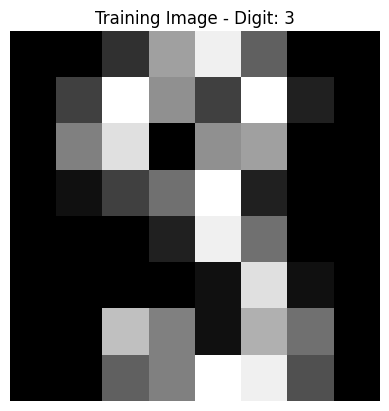

Original shape of x_new: (8, 8)
Flattened shape of x_new: (1, 64)
Predicted digit: 3


In [201]:
# --- Display and Test One Training Image ---
# Select an image from the training set (e.g., first image)
idx = np.random.randint(0, X_val[0].shape)
# Since X_train contains flattened images, reshape it back to 8x8 for display.
img = X_train[idx].reshape(8, 8)
label = np.argmax(y_train[idx])

# Save the image array to a file. Note that the file name comes first.
np.save("test.npy", img)

plt.imshow(img, cmap='gray')
plt.title(f"Training Image - Digit: {label}")
plt.axis('off')
plt.show()

W1 = np.load('W1.npy')
b1 = np.load('b1.npy')
W2 = np.load('W2.npy')
b2 = np.load('b2.npy')

# Load the test image. This image is expected to be an 8x8 array.
x_new = np.load('test.npy')
print("Original shape of x_new:", x_new.shape)  # Should output: (8, 8)

# Flatten the image so that it has shape (1, 64)
x_new = x_new.reshape(1, -1)
print("Flattened shape of x_new:", x_new.shape)  # Should output: (1, 64)

# Perform the forward pass
A1_new = sigmoid(np.dot(x_new, W1) + b1)
A2_new = sigmoid(np.dot(A1_new, W2) + b2)
prediction = np.argmax(A2_new)
print("Predicted digit:", prediction)

In [202]:
# --- Perform Predictions on the Test Set Using the Loaded Weights ---
# Forward pass:
# 1. Compute activations for the hidden layer.
Z1 = np.dot(X_val, W1) + b1   # Linear combination for the hidden layer.
A1 = sigmoid(Z1)              # Apply sigmoid activation.

# 2. Compute activations for the output layer.
Z2 = np.dot(A1, W2) + b2       # Linear combination for the output layer.
A2 = sigmoid(Z2)              # Output activations.

# The predicted class for each sample is the one with the highest activation.
predictions = np.argmax(A2, axis=1)
true_labels = np.argmax(y_val, axis=1)

# Calculate the accuracy of the model on the test set.
accuracy = np.mean(predictions == true_labels)
print("Test set accuracy: {:.2f}%".format(accuracy * 100))

Test set accuracy: 97.50%


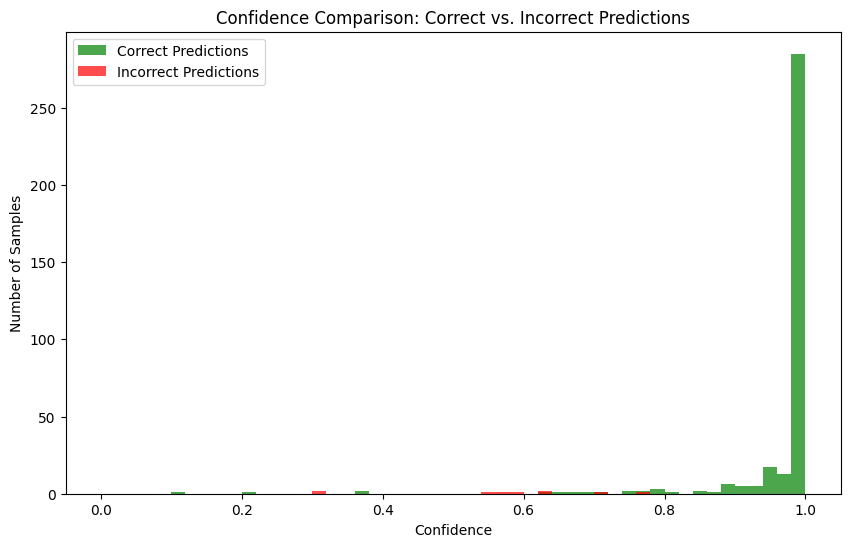

In [203]:
def plot_confidence_comparison(probabilities, true_labels, bins=20):
    """
    Plots histograms comparing the confidence scores for correctly vs.
    incorrectly classified samples.
    
    Parameters:
        probabilities (np.ndarray): A 2D array of shape (n_samples, n_classes) 
            containing the predicted probabilities (e.g., outputs of softmax).
        true_labels (np.ndarray): A 1D array of true labels (integers) of shape (n_samples,).
            If your labels are in one-hot format, convert them using np.argmax.
        bins (int): Number of bins for the histogram.
    """
    # Compute predicted labels (choose the class with the highest probability).
    predictions = np.argmax(probabilities, axis=1)
    
    # Compute the confidence for each prediction as the maximum probability.
    confidences = np.max(probabilities, axis=1)

    # Create consistent bin edges from 0 to 1.
    bin_edges = np.linspace(0, 1, bins + 1)
    
    # Separate confidence scores based on whether the prediction was correct.
    correct_confidences = confidences[predictions == true_labels]
    incorrect_confidences = confidences[predictions != true_labels]
    
    # Plot histograms for the two groups.
    plt.figure(figsize=(10, 6))
    plt.hist(correct_confidences, bins=bin_edges, alpha=0.7, label='Correct Predictions', color='green')
    plt.hist(incorrect_confidences, bins=bin_edges, alpha=0.7, label='Incorrect Predictions', color='red')
    plt.xlabel('Confidence')
    plt.ylabel('Number of Samples')
    plt.title('Confidence Comparison: Correct vs. Incorrect Predictions')
    plt.legend()
    plt.show()

plot_confidence_comparison(A2, true_labels, 50)

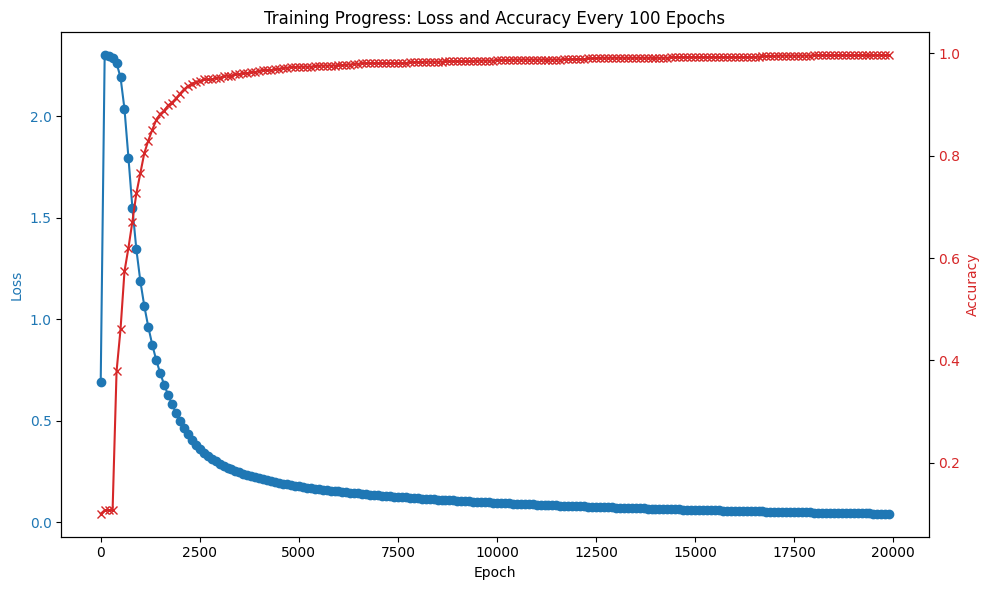

In [204]:
# --- Function to Plot Training Progress ---
def plot_training_progress(csv_filepath):
    """
    Reads a CSV file with training progress data (epoch, loss, accuracy)
    and plots the loss and accuracy.
    """
    epochs_list = []
    losses_list = []
    accuracies_list = []
    
    with open(csv_filepath, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            epochs_list.append(float(row["epoch"]))
            losses_list.append(float(row["loss"]))
            accuracies_list.append(float(row["accuracy"]))
    
    # Plot loss and accuracy on a dual y-axis plot
    fig, ax1 = plt.subplots(figsize=(10,6))
    
    color_loss = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color_loss)
    ax1.plot(epochs_list, losses_list, color=color_loss, marker='o', label='Loss')
    ax1.tick_params(axis='y', labelcolor=color_loss)
    
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
    color_acc = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color_acc)
    ax2.plot(epochs_list, accuracies_list, color=color_acc, marker='x', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_acc)
    
    plt.title('Training Progress: Loss and Accuracy Every 100 Epochs')
    fig.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function to plot the training progress
plot_training_progress(csv_filename)